<a href="https://colab.research.google.com/github/aircable/xor-neural-network-demo/blob/main/Skin_Cancer_Detection_multi_modal_with_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setting Up the Environment and Importing Data Sources

This Jupyter Notebook is designed for a skin cancer detection task and utilizes image datasets sourced from Kaggle, a popular platform for data science competitions and datasets.

To begin, we need to import the necessary data. The code cell below uses the `kagglehub.dataset_download` function. This function is part of the Kaggle API tools and serves a crucial purpose:
*   **`kagglehub.dataset_download`**: It connects to Kaggle, downloads the specified datasets, and makes them available within the notebook's environment for analysis and model training.

The datasets being imported are:
1.  **`fanconic/skin-cancer-malignant-vs-benign`**: This dataset likely contains images of skin lesions classified as either malignant (cancerous) or benign (non-cancerous).
2.  **`bhaveshmittal/melanoma-cancer-dataset`**: This dataset is focused on melanoma, a specific and dangerous type of skin cancer, providing more images for training our detection model.

Running the following code cell will ensure these datasets are ready for use in the subsequent steps of the notebook.

In [ ]:
## Step 1: Setting Up the Environment and Importing Data Sources

# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')
bhaveshmittal_melanoma_cancer_dataset_path = kagglehub.dataset_download('bhaveshmittal/melanoma-cancer-dataset')

print('Data source import complete.')


Data source import complete.


### 1.1 Importing Essential Libraries - The AI/ML Toolkit

Before we can start building our skin cancer detection model, we need to equip ourselves with the right tools. The following code cell imports several key Python libraries that are fundamental for any Artificial Intelligence (AI) and Machine Learning (ML) project, especially those involving image data and deep learning:

*   **NumPy (`np`)**: The cornerstone for numerical computing in Python. NumPy provides powerful tools for handling arrays and matrices, which are essential for representing and manipulating data like image pixels and model parameters.

*   **PyTorch (`torch`, `torch.nn`, `torch.optim`, `torchvision`)**: This is a leading deep learning framework.
    *   `torch`: The main PyTorch library, providing tensor computation (similar to NumPy arrays but with GPU acceleration) and core functionalities.
    *   `torch.nn`: A module for building neural networks. It offers pre-defined layers, loss functions, and other building blocks.
    *   `torch.optim`: Contains optimization algorithms like Adam or SGD, which are used to update model parameters during training.
    *   `torchvision`: Part of PyTorch, specifically for computer vision tasks. It includes tools for loading and transforming image datasets, as well as pre-trained models.

*   **Scikit-learn (`sklearn.metrics`)**: A versatile machine learning library. Here, we're specifically importing `metrics` to evaluate our model's performance. This includes calculating:
    *   Accuracy: The proportion of correctly classified images.
    *   Precision: The ability of the model not to label a benign case as malignant.
    *   Recall (Sensitivity): The ability of the model to find all malignant cases.
    *   F1-score: A weighted average of precision and recall.
    *   Confusion Matrix: A table showing the actual vs. predicted classifications, helping to visualize errors.

*   **Matplotlib & Seaborn**: These are popular libraries for data visualization.
    *   `matplotlib.pyplot (plt)`: A fundamental plotting library, allowing us to create graphs of training progress, loss curves, etc.
    *   `seaborn (sns)`: Built on top of Matplotlib, Seaborn provides more statistically sophisticated and aesthetically pleasing visualizations, such as heatmaps for confusion matrices.

Finally, `from warnings import filterwarnings` and `filterwarnings('ignore')` is a utility to suppress warning messages. While warnings can be useful, sometimes they can clutter the output with less critical information. This line helps in keeping the notebook's output cleaner.

### 3.2 Building a Custom Convolutional Neural Network (CNN) from Scratch

In addition to using pre-trained models, we are also defining a `CustomCNN` from scratch. This allows for more control over the architecture and can be a good learning exercise. It might also be useful if pre-trained models are too complex or if we want to experiment with novel architectures tailored to our specific dataset.

This custom CNN uses several standard neural network layers provided by PyTorch's `nn` module:

*   **`nn.Conv2d(in_channels, out_channels, kernel_size, padding)`**: These are 2D convolutional layers, the core of CNNs for image processing.
    *   `in_channels`: Number of channels in the input image (e.g., 3 for RGB).
    *   `out_channels`: Number of filters the layer learns. Each filter detects different features.
    *   `kernel_size`: Size of the convolutional filter (e.g., 3x3 or 5x5 pixels).
    *   `padding`: Adds pixels to the image border, which can help preserve spatial dimensions after convolution.
    *   *Role*: They extract features like edges, textures, and more complex patterns by sliding filters over the input image.

*   **`nn.BatchNorm2d(num_features)`**: Batch Normalization layer.
    *   *Role*: Normalizes the activations of the previous layer across the current batch. This helps in stabilizing the learning process, speeding up training, and can sometimes act as a regularizer.

*   **`nn.MaxPool2d(kernel_size)`**: Max Pooling layer.
    *   *Role*: Reduces the spatial dimensions (height and width) of the feature maps. It takes the maximum value from a window (defined by `kernel_size`) in the feature map, thus retaining the most activated features while reducing computational load and providing a degree of translation invariance.

*   **`nn.Linear(in_features, out_features)`**: A fully connected (or dense) layer.
    *   *Role*: These layers perform classification based on the high-level features extracted by the convolutional layers. Each neuron in a linear layer is connected to every neuron in the previous layer.

*   **`nn.Dropout(p)`**: Dropout layer.
    *   *Role*: A regularization technique to prevent overfitting. During training, it randomly sets a fraction `p` of input units to 0 at each update. This forces the network to learn more robust features that are not overly reliant on any single neuron.

*   **`F.leaky_relu` (or `nn.LeakyReLU`)**: Leaky Rectified Linear Unit activation function.
    *   *Role*: Activation functions introduce non-linearity into the model, allowing it to learn more complex patterns. ReLU sets all negative values to zero, while Leaky ReLU allows a small, non-zero gradient for negative inputs, which can help mitigate the "dying ReLU" problem where neurons can become inactive.

**Structure of `CustomCNN`:**
The `CustomCNN` defined below consists of a sequence of these layers:
1.  Multiple blocks of: Convolutional Layer -> Batch Normalization -> Leaky ReLU Activation -> Max Pooling.
2.  These are followed by a flattening operation to convert the 2D feature maps into a 1D vector.
3.  Finally, one or more Fully Connected (Linear) layers, with Leaky ReLU activation and Dropout, perform the final classification.

The `_init_fc_layers` method is a clever way to dynamically determine the input size for the first fully connected layer based on the output shape of the convolutional/pooling layers, making the network more flexible to changes in input image size or convolutional architecture.

In [ ]:
### 1.1 Importing Essential Libraries - The AI/ML Toolkit

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

### 1.2 Checking for GPU Acceleration - Speeding Up Training

Deep learning models, especially those for image analysis, involve a massive number of calculations. Training these models can be very time-consuming on a standard Central Processing Unit (CPU).

Graphics Processing Units (GPUs) are specialized hardware designed for parallel processing, making them significantly faster for the types of computations required in deep learning. Using a GPU can reduce training time from days to hours, or hours to minutes.

The code cell below checks if a CUDA-enabled GPU is available to PyTorch:
*   **`torch.cuda.is_available()`**: This PyTorch function returns `True` if a compatible NVIDIA GPU (with CUDA support) is detected and properly configured, and `False` otherwise.

Based on this check, the code sets a variable named `device`:
*   If a GPU is available (`torch.cuda.is_available()` is `True`), `device` is set to `'cuda'`.
*   Otherwise (no GPU or incompatible GPU), `device` defaults to `'cpu'`.

This `device` variable will then be used throughout the notebook to ensure that our data and models are processed on the appropriate hardware (GPU if available, for speed, or CPU if not).

The output of the code cell will print which device (`cuda` or `cpu`) is being used for this session.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


## Step 2: Preparing the Image Data - Augmentation and Transformation

**Data Augmentation** is a technique used to artificially increase the size of a training dataset by creating modified versions of its existing images. This is crucial in deep learning for several reasons:
*   **Increases Dataset Size**: More data generally leads to better model performance and generalization.
*   **Enhances Model Robustness**: By exposing the model to a wider variety of image variations (rotations, flips, etc.), it becomes less sensitive to these changes in real-world images and can perform better.
*   **Prevents Overfitting**: Overfitting occurs when a model learns the training data too well, including its noise, and performs poorly on unseen data. Augmentation helps the model learn more general features.

We use `torchvision.transforms.Compose` to create a pipeline of image transformations. This function allows us to chain multiple transformation operations together. The transformations defined in the `transformer` variable below are applied to the **training data**:

*   **`transforms.RandomRotation(degrees=20)`**: Randomly rotates the images by an angle between -20 and +20 degrees. This helps the model become invariant to the orientation of objects.
*   **`transforms.RandomHorizontalFlip(p=0.3)`**: Randomly flips the images horizontally with a probability of 0.3 (30% of the time). This is useful if the left-right orientation doesn't change the meaning of the image (e.g., a skin lesion is still a lesion if flipped).
*   **`transforms.RandomVerticalFlip(p=0.3)`**: Similarly, randomly flips the images vertically with a 30% probability.
*   **`transforms.Resize(size=(imgSize, imgSize), antialias=True)`**: Resizes the input image to a fixed square size, defined by `imgSize`. `antialias=True` helps in smoother resizing.
*   **`transforms.CenterCrop(size=(imgSize, imgSize))`**: Crops the image from the center to ensure it's exactly `imgSize` x `imgSize`. This is often done after resizing to ensure the dimensions are precise.
*   **`transforms.ToTensor()`**: Converts the image (which is usually in PIL Image format or a NumPy array) into a PyTorch tensor. Tensors are the fundamental data structure used in PyTorch for computations. This step also typically scales pixel values from a 0-255 range to a 0.0-1.0 range.
*   **`transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`**: Normalizes the tensor image by subtracting the `mean` and dividing by the `standard deviation` for each color channel (Red, Green, Blue). These specific mean and standard deviation values are commonly used as they are derived from the ImageNet dataset, a large benchmark dataset. Normalization helps the model converge faster during training by ensuring that the input features have a similar range of values.

The `valTransformer` is defined for the **validation data**. It typically includes fewer augmentations. We want to evaluate the model on data that is as close as possible to what it might see in a real-world scenario, without random alterations. Therefore, it usually only includes necessary transformations like resizing, center cropping, conversion to a tensor, and normalization to ensure consistency with the training data's preprocessing.

In [ ]:

imgSize = 112
# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

### 2.1 Loading Image Datasets from Folders

With our augmentation and transformation pipelines (`transformer` for training, `valTransformer` for validation) defined, we can now load the image datasets.

PyTorch's `torchvision.datasets.ImageFolder` is a convenient utility for loading image data when it's organized in a specific way:
*   **`datasets.ImageFolder(root, transform)`**: This function expects the data to be in a root directory (`root`) where each subfolder's name corresponds to a class label. For example, if our `root` path is `/kaggle/input/melanoma-cancer-dataset/train`, `ImageFolder` will look for subfolders like `/kaggle/input/melanoma-cancer-dataset/train/benign` and `/kaggle/input/melanoma-cancer-dataset/train/malignant`. It will automatically label all images in the 'benign' folder as 'benign' and those in 'malignant' as 'malignant'.

The `transform` argument is crucial:
*   For `trainData`, we pass `transformer`. This means every image loaded from the training path will undergo the random augmentations and normalization steps we defined earlier.
*   For `valData` (validation data), we pass `valTransformer`. This applies the more limited set of transformations (resize, crop, ToTensor, Normalize) to the validation images, ensuring a consistent evaluation.

The code cell below sets the `path` for training data and `valPath` for validation/test data and then uses `ImageFolder` to create dataset objects.

In [ ]:
path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

### 2.2 Creating DataLoaders - Efficiently Feeding Data to the Model

Once we have our datasets (`trainData` and `valData`), we need an efficient way to feed these images to our neural network during training and validation. This is where `torch.utils.data.DataLoader` comes in.

A `DataLoader` is a PyTorch utility that takes a Dataset object (like the ones we created with `ImageFolder`) and provides an iterable over it. It offers several important functionalities for training deep learning models:

*   **Batching**: Instead of processing images one by one, a `DataLoader` groups them into batches. This is more computationally efficient, especially when using GPUs, as it allows for parallel processing of multiple samples at once. The `batch_size` parameter determines how many images are in each batch.
    *   A larger batch size can lead to faster training per epoch but requires more memory. It can also sometimes lead to a more stable gradient estimate, but too large can sometimes hinder generalization.
*   **Shuffling**: For the training data (`trainLoader`), it's crucial to shuffle the images at the beginning of each epoch (`shuffle=True`). This ensures that the model doesn't learn any unintended patterns based on the order of images in the dataset and helps in better generalization.
    *   For the validation data (`valLoader`), shuffling is typically not necessary (`shuffle=False`) because we want a consistent evaluation of the model's performance on the same sequence of validation images epoch after epoch.
*   **Parallel Loading (`num_workers`)**: `DataLoader` can use multiple subprocesses (workers) to load data in parallel from the disk to the memory (and then to the GPU). This can significantly speed up training by preventing the GPU from waiting for data to be loaded by the CPU. `num_workers = 4` means four subprocesses will be used for data loading.

The code cell below defines `trainLoader` for our training data and `valLoader` for our validation data, configured with appropriate batch sizes and shuffling options.

In [ ]:
### 2.2 Creating DataLoaders - Efficiently Feeding Data to the Model
batchSize = 256

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

## Step 3: Defining the Neural Network Architectures - Our Brains for Image Classification

### 3.1 Leveraging Pre-trained Models: VGG16 and ResNet50 (Transfer Learning)

Instead of building our image classification models entirely from scratch, which would require a very large dataset and extensive training time, we can leverage **pre-trained models**. These are sophisticated neural network architectures that have already been trained on massive image datasets, most commonly the ImageNet dataset (which contains millions of images across 1000 categories).

The key idea here is **Transfer Learning**. We transfer the knowledge (the learned features like edges, textures, and complex patterns) from these pre-trained models to our specific task of skin cancer detection. This approach offers several advantages:
*   **Reduced Training Time**: Since the model has already learned to extract general image features, we only need to fine-tune it for our specific dataset.
*   **Better Performance with Smaller Datasets**: Pre-trained models provide a strong foundation, often leading to better results than training a model from scratch, especially when our own dataset is relatively small.
*   **Effective Feature Extraction**: These models are known for their excellent ability to extract hierarchical features from images.

In this notebook, we will use two popular and powerful Convolutional Neural Network (CNN) architectures:
*   **VGG16**: Known for its simple and uniform architecture consisting of 16 layers with learnable weights (convolutional and fully connected layers).
*   **ResNet50**: A 50-layer Residual Network that introduced "skip connections" to help train very deep networks more effectively by mitigating the vanishing gradient problem.

**Loading Pre-trained Weights:**
When we initialize these models using `models.vgg16(weights='DEFAULT')` and `models.resnet50(weights='DEFAULT')`, PyTorch automatically downloads and loads the weights that were learned from training on the ImageNet dataset. The `'DEFAULT'` (or sometimes `pretrained=True` in older versions) signifies that we want these pre-learned feature extraction capabilities.

**Modifying the Final Classifier Layer:**
Since VGG16 and ResNet50 were originally trained to classify images into 1000 ImageNet classes, their final layer (the classifier or fully connected layer) is designed for this 1000-class output. For our skin cancer detection task, we typically have a binary classification problem (e.g., 'benign' vs. 'malignant'). Therefore, we need to replace the original final layer with a new one suited to our task:

*   For VGG16 (`model1`), the classifier is a sequence of layers. We replace the last layer (`model1.classifier[6]`) with a new `nn.Linear` layer. `model1.classifier[6].in_features` gives us the number of input features coming into the original last layer, and we change the output to `1` neuron. This single neuron's output will typically be passed through a sigmoid activation function later to produce a probability (e.g., probability of being malignant).

*   For ResNet50 (`model2`), the final fully connected layer is typically named `fc`. We replace `model2.fc` with a new `nn.Linear` layer. `model2.fc.in_features` provides the number of input features from the preceding layer, and again, we set the output to `1` neuron for our binary classification.

This modification allows us to use the powerful feature extraction learned from ImageNet while tailoring the classification part of the model to our specific skin cancer detection problem.

In [ ]:
# Using a pre-trained EfficientNetV2L model
model1 = models.vgg16(weights = 'DEFAULT')

# Modifying final classifier layer
model1.classifier[6] = nn.Linear(model1.classifier[6].in_features, 1)

model2= models.resnet50(weights='DEFAULT')
in_features= model2.fc.in_features
model2.fc= nn.Linear(in_features, 1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.8MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.5MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(CustomCNN, self).__init__()

        # Convolutional layers - feature extraction part
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1) # 3 input channels (RGB), 32 output filters, 3x3 kernel, padding 1
        self.bn1 = nn.BatchNorm2d(32) # Batch normalization for 32 features
        self.pool1 = nn.MaxPool2d(2) # Max pooling with 2x2 window

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 input channels, 64 output filters, 3x3 kernel, padding 1
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=1) # 64 input channels, 128 output filters, 5x5 kernel, padding 1
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 128 input channels, 128 output filters, 3x3 kernel, padding 1
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=7, padding=1) # 128 input channels, 256 output filters, 7x7 kernel, padding 1
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2)

        self._init_fc_layers() # Initialize fully connected layers dynamically

    # Forward pass through convolutional layers (feature extraction)
    def _forward_conv(self, x):
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.leaky_relu(self.bn5(self.conv5(x))))

        return x

    # Dynamically initialize fully connected layers based on conv output shape
    def _init_fc_layers(self):
        with torch.no_grad(): # No need to track gradients here
            # Create a dummy input tensor (batch size 1, 3 channels, 112x112 image)
            dummy = torch.zeros(1, 3, 112, 112)
            # Pass the dummy tensor through the convolutional layers
            dummy = self._forward_conv(dummy)
            # Flatten the output of conv layers to get the number of features for the FC layer
            flatten_size = dummy.view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_size, 256) # Fully connected layer 1
        self.dropout = nn.Dropout(0.5) # Dropout layer with 50% probability
        self.leaky_relu = nn.LeakyReLU(0.01) # Leaky ReLU activation
        self.fc2 = nn.Linear(256, 1) # Output layer (1 neuron for binary classification)

    # Defines the data flow through the network
    def forward(self, x):
        x = self._forward_conv(x) # Pass through convolutional layers
        x = x.view(x.size(0), -1) # Flatten the output for FC layers
        x = F.leaky_relu(self.fc1(x)) # Apply FC1 and Leaky ReLU
        x = self.dropout(x) # Apply dropout
        x = self.leaky_relu(self.fc2(x)) # Apply FC2 and Leaky ReLU (often sigmoid is applied outside the model for BCEWithLogitsLoss)
        return x


## Step 4: Preparing Models for Training - Optimization and Regularization Strategies

### 4.1 Enabling Data Parallelism - Using Multiple GPUs (If Available)

If multiple GPUs are available in the training environment, we can leverage them to speed up the training process. PyTorch provides a simple way to do this using `nn.DataParallel`.

*   **`nn.DataParallel(model)`**: This wrapper automatically distributes the input data (batches) across the available GPUs. In each forward pass, the model is replicated on each GPU, each replica processes a portion of the batch, and then the gradients are collected and averaged on the main GPU during the backward pass to update the model parameters. This can lead to significant speedups in training time, roughly proportional to the number of GPUs used (though there's some overhead).

*   **`.to(device)`**: After wrapping the model with `nn.DataParallel`, we again use `.to(device)` to move the model (and its parallelized operations) to the appropriate device. If `device` is 'cuda' (meaning GPUs are available), the model will be set up for multi-GPU training. If `device` is 'cpu', `nn.DataParallel` won't have a practical effect but also won't cause errors.

This operation is applied to all three of our models (`model1` - VGG16, `model2` - ResNet50, and `model3` - CustomCNN) to ensure they can utilize multiple GPUs if present.

In [ ]:
model1 = nn.DataParallel(model1).to(device)
model2 = nn.DataParallel(model2).to(device)
model3 = CustomCNN(input_channels=3).to(device)
model3 = nn.DataParallel(model3)

### 4.2 Defining the Loss Function, Optimizers, and Learning Rate Schedulers

To train our neural networks, we need to define a few key components:

**1. Loss Function (`criterion`)**
*   **What it is**: A loss function quantifies how well our model is performing. It measures the difference (or "loss") between the model's predicted output and the actual target labels. The goal of training is to minimize this loss.
*   **`nn.BCEWithLogitsLoss()`**: We're using Binary Cross Entropy with Logits Loss.
    *   This loss function is particularly well-suited for **binary classification problems** (where there are two possible output classes, like 'benign' or 'malignant').
    *   It cleverly combines a Sigmoid activation function (which squashes outputs to a 0-1 probability range) and the Binary Cross Entropy (BCE) loss into a single class.
    *   Using `BCEWithLogitsLoss` is generally more numerically stable than applying a separate Sigmoid layer followed by a standard `BCELoss`, as it can prevent issues with vanishing gradients when the sigmoid output is very close to 0 or 1.

**2. Optimizers (`optimizer1`, `optimizer2`, `optimizer3`)**
*   **What they do**: An optimizer is an algorithm that adjusts the model's parameters (weights and biases) in response to the loss calculated. It uses the gradients computed during backpropagation to guide these updates, aiming to minimize the loss function.
*   **`optim.Adam(model.parameters(), lr=0.001)`**: We are using the Adam optimizer for each of our three models.
    *   Adam (Adaptive Moment Estimation) is a popular and effective optimization algorithm that adapts the learning rate for each parameter. It's known for its efficiency and often works well with default settings.
    *   `model.parameters()`: This tells the optimizer which parameters it needs to update (all learnable parameters of the respective model).
    *   `lr=0.001`: This is the **initial learning rate**. The learning rate determines the step size the optimizer takes during each parameter update. A value of 0.001 is a common starting point.
*   *Note*: A separate optimizer is instantiated for each model (`model1`, `model2`, `model3`) because they are trained independently before their predictions are combined in the ensemble.

**3. Learning Rate Schedulers (`scheduler1`, `scheduler2`, `scheduler3`)**
*   **What they do**: A learning rate scheduler dynamically adjusts the learning rate during the training process. Starting with a relatively higher learning rate can help the model learn quickly initially, while gradually reducing it can help the model fine-tune its weights and converge to a better minimum of the loss function.
*   **`ReduceLROnPlateau(optimizer, threshold=0.01, factor=0.1, patience=3, min_lr=1e-5, verbose=True)`**: We're using the `ReduceLROnPlateau` scheduler.
    *   This scheduler monitors a specified metric (typically validation loss) and reduces the learning rate when this metric stops improving.
    *   `optimizer`: The optimizer whose learning rate will be adjusted.
    *   `threshold=0.01`: The minimum relative improvement required to consider the metric as improving.
    *   `factor=0.1`: The factor by which the learning rate will be reduced (e.g., new_lr = old_lr * 0.1).
    *   `patience=3`: The number of epochs to wait for improvement before reducing the learning rate. If the monitored metric doesn't improve for 3 consecutive epochs, the learning rate is reduced.
    *   `min_lr=1e-5`: The minimum allowable learning rate; the scheduler won't reduce it below this value.
    *   `verbose=True`: This will print a message to the console each time the learning rate is updated, which is helpful for monitoring the training process.
*   *Note*: Similar to optimizers, a separate scheduler is defined for each model's optimizer.

In [ ]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()

optimizer1 = optim.Adam(model1.parameters(), lr = 0.001)
optimizer2 = optim.Adam(model2.parameters(), lr = 0.001)
optimizer3 = optim.Adam(model2.parameters(), lr = 0.001)

scheduler1 = ReduceLROnPlateau(optimizer1, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
scheduler2 = ReduceLROnPlateau(optimizer2, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
scheduler3 = ReduceLROnPlateau(optimizer3, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

### 4.3 Implementing Early Stopping - Preventing Overfitting

**Early stopping** is a form of regularization used to prevent overfitting when training a neural network (or any iterative machine learning model). Overfitting happens when a model learns the training data too well, including its noise and specific quirks, and as a result, performs poorly on new, unseen data (like the validation or test set).

**How it Works:**
The core idea of early stopping is to monitor the model's performance on a validation dataset during training. Typically, we look at the validation loss:
1.  At the end of each epoch, the model is evaluated on the validation set.
2.  If the validation loss stops decreasing (or another chosen metric like validation accuracy stops increasing) for a certain number of consecutive epochs (defined by `patience`), the training process is halted.
3.  The model weights that achieved the best performance on the validation set are usually saved and considered the final model.

This prevents the model from continuing to train and potentially overfit to the training data once its ability to generalize to unseen data (the validation set) starts to degrade.

**Variables Initialized Below:**
The code cell below initializes variables needed to implement early stopping for each of our three models independently:

*   **`patience = 5`**: This is the number of epochs the training process will wait for an improvement in validation loss before stopping. If the validation loss doesn't get better than the `bestLossN` by at least `minDelta` for 5 consecutive epochs, training for that model will stop.
*   **`minDelta = 0.01`**: This defines the minimum change in the monitored quantity (validation loss) that qualifies as an improvement. If the validation loss decreases, but by less than `minDelta`, it might not be considered a significant enough improvement to reset the patience counter.
*   **`currentPatienceN` (e.g., `currentPatience1`, `currentPatience2`, `currentPatience3`)**: These are counters that track how many epochs have passed without a significant improvement in validation loss for each respective model. They are initialized to 0.
*   **`bestLossN` (e.g., `bestLoss1`, `bestLoss2`, `bestLoss3`)**: These variables will store the lowest validation loss observed so far during training for each model. They are initialized to positive infinity (`float('inf')`) so that the first validation loss encountered will always be lower.

In [ ]:
patience = 5
minDelta = 0.01

currentPatience1 = 0
bestLoss1 = float('inf')

currentPatience2 = 0
bestLoss2 = float('inf')

currentPatience3 = 0
bestLoss3 = float('inf')

# Check for saved model in Google Drive

In [ ]:
# ---------------------------------------------------------------
# Persistent Model Storage with Google Drive in Colab
# ---------------------------------------------------------------
# This code mounts your Google Drive, checks for existing models
# in Notebooks/models, and loads them if they exist.
# If models are missing, they will be trained and saved later.
# This way, you don't lose your progress if Colab disconnects.
# ---------------------------------------------------------------

import os

# Mount Google Drive to access persistent storage
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

# Directory where models will be stored (in your Google Drive)
MODEL_DIR = '/content/drive/MyDrive/Notebooks/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Define model filenames
model_filenames = [
    'SkinCancerModel1.h5',
    'SkinCancerModel2.h5',
    'SkinCancerModel3.h5'
]

# Try to load each model from Google Drive if it exists
models = []
model_exists = []

for fname in model_filenames:
    model_path = os.path.join(MODEL_DIR, fname)
    if os.path.exists(model_path):
        print(f"Found {fname} in Google Drive. Loading model...")
        model = tf.keras.models.load_model(model_path)
        models.append(model)
        model_exists.append(True)
    else:
        print(f"{fname} not found in Google Drive. Will train and save later.")
        models.append(None)  # Placeholder for model to be trained
        model_exists.append(False)

# Unpack models for easy access (model1, model2, model3)
model1, model2, model3 = models



# Now, throughout your notebook, use model1, model2, and model3 as usual.
# If a model exists, it will be loaded. If not, it will be trained and saved.

# Training Model

In [ ]:
# Gradient scaler for mixed-precision training
scaler1 = GradScaler()
scaler2 = GradScaler()
scaler3 = GradScaler()


# Lists to store training and validation metrics
trainLosses1 = []
valLosses1 = []
valAccs1 = []

trainLosses2 = []
valLosses2 = []
valAccs2= []

trainLosses3 = []
valLosses3 = []
valAccs3 = []

# Training loop
epochs = 40

for epoch in range(epochs):
    # Training phase
    model1.train()
    model2.train()
    model3.train()

    runningLoss1 = 0.0
    runningLoss2= 0.0
    runningLoss3= 0.0


    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        with autocast():
            outputs1 = model1(inputs)
            loss1 = criterion(outputs1, labels)

            outputs2 = model2(inputs)
            loss2 = criterion(outputs2, labels)

            outputs3 = model3(inputs)
            loss3 = criterion(outputs3, labels)

        scaler1.scale(loss1).backward()
        scaler1.step(optimizer1)
        scaler1.update()

        scaler2.scale(loss2).backward()
        scaler2.step(optimizer2)
        scaler2.update()

        scaler3.scale(loss3).backward()
        scaler3.step(optimizer3)
        scaler3.update()

        runningLoss1 += loss1.item()
        runningLoss2 += loss2.item()
        runningLoss3 += loss3.item()

    trainLoss1 = runningLoss1 / len(trainLoader)
    trainLoss2 = runningLoss2 / len(trainLoader)
    trainLoss3 = runningLoss3 / len(trainLoader)


    print(f'Epoch {epoch + 1}/{epochs} - Training Loss vgg16: {trainLoss1:.2f},Training Loss resnet50: {trainLoss2:.2f}, Training Loss custom cnn: {trainLoss3:.2f}')
    trainLosses1.append(trainLoss1)
    trainLosses2.append(trainLoss2)
    trainLosses3.append(trainLoss3)


    # Validation phase
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        valLoss1 = 0.0
        valLoss2 =0.0
        valLoss3 =0.0

        correct1 = total1 = 0
        correct2 = total2 = 0
        correct3 = total3 = 0


        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs1 = model1(inputs)
            loss1 = criterion(outputs1, labels)
            valLoss1 += loss1.item()

            predicted1 = (torch.sigmoid(outputs1) > 0.5).float()
            total1 += labels.size(0)
            correct1 += (predicted1 == labels).sum().item()


            outputs2 = model2(inputs)
            loss2 = criterion(outputs2, labels)
            valLoss2 += loss2.item()

            predicted2 = (torch.sigmoid(outputs2) > 0.5).float()
            total2 += labels.size(0)
            correct2 += (predicted2 == labels).sum().item()

            outputs3 = model3(inputs)
            loss3 = criterion(outputs3, labels)
            valLoss3 += loss3.item()

            predicted3 = (torch.sigmoid(outputs3) > 0.5).float()
            total3 += labels.size(0)
            correct3 += (predicted3 == labels).sum().item()

        avgLoss1 = valLoss1 / len(valLoader)
        accuracy1 = correct1 / total1 * 100

        avgLoss2 = valLoss2 / len(valLoader)
        accuracy2 = correct2 / total2 * 100

        avgLoss3 = valLoss3 / len(valLoader)
        accuracy3 = correct3 / total3 * 100

        print(f' Vgg16 Validation Loss : {avgLoss1:.2f} Validation Accuracy : {accuracy1:.2f}%\n')
        print(f'Resnet50 Validation Loss : {avgLoss2:.2f} Validation Accuracy : {accuracy2:.2f}%\n')
        print(f'custom cnn Validation Loss : {avgLoss3:.2f} Validation Accuracy : {accuracy3:.2f}%\n')

        valLosses1.append(avgLoss1)
        valAccs1.append(accuracy1)

        valLosses2.append(avgLoss2)
        valAccs2.append(accuracy2)

        valLosses3.append(avgLoss3)
        valAccs3.append(accuracy3)

        # Early stopping
        if avgLoss1 < bestLoss1 - minDelta:
            bestLoss1 = avgLoss1
            currentPatience1 = 0
        else:
            currentPatience1 += 1
            if currentPatience1 >= patience:
                print('Early stopping triggered.')
                break

        scheduler1.step(avgLoss1)

        if avgLoss2 < bestLoss2 - minDelta:
            bestLoss2 = avgLoss2
            currentPatience2 = 0
        else:
            currentPatience2 += 1
            if currentPatience2 >= patience:
                print('Early stopping triggered.')
                break

        scheduler2.step(avgLoss2)

        if avgLoss3 < bestLoss3 - minDelta:
            bestLoss3 = avgLoss3
            currentPatience3 = 0
        else:
            currentPatience3 += 1
            if currentPatience3 >= patience:
                print('Early stopping triggered.')
                break

        scheduler3.step(avgLoss3)

# finished training
# save models to drive
if not model_exists[0]: model1.save(os.path.join(MODEL_DIR, model_filenames[0]))
if not model_exists[1]: model2.save(os.path.join(MODEL_DIR, model_filenames[1]))
if not model_exists[2]: model3.save(os.path.join(MODEL_DIR, model_filenames[2]))

Epoch 1/40 - Training Loss vgg16: 1.20,Training Loss resnet50: 0.30, Training Loss custom cnn: 0.70
 Vgg16 Validation Loss : 0.53 Validation Accuracy : 74.10%

Resnet50 Validation Loss : 0.31 Validation Accuracy : 85.75%

custom cnn Validation Loss : 0.69 Validation Accuracy : 48.85%

Epoch 2/40 - Training Loss vgg16: 0.41,Training Loss resnet50: 0.24, Training Loss custom cnn: 0.70
 Vgg16 Validation Loss : 0.48 Validation Accuracy : 70.25%

Resnet50 Validation Loss : 0.23 Validation Accuracy : 91.10%

custom cnn Validation Loss : 0.69 Validation Accuracy : 49.55%

Epoch 3/40 - Training Loss vgg16: 0.34,Training Loss resnet50: 0.21, Training Loss custom cnn: 0.70
 Vgg16 Validation Loss : 0.34 Validation Accuracy : 86.05%

Resnet50 Validation Loss : 0.25 Validation Accuracy : 90.25%

custom cnn Validation Loss : 0.69 Validation Accuracy : 49.65%

Epoch 4/40 - Training Loss vgg16: 0.31,Training Loss resnet50: 0.20, Training Loss custom cnn: 0.70
 Vgg16 Validation Loss : 0.31 Validation A

# Model Size Evaluation and Conversion for Embedded Deployment

In [ ]:
# ---------------------------------------------------------------
# Model Size Evaluation and Conversion for Embedded Deployment
# ---------------------------------------------------------------
# This code saves your trained models, measures their sizes,
# and converts them to TensorFlow Lite format (with and without quantization).
# Quantization is essential for running models efficiently on small devices.
# ---------------------------------------------------------------

import os
import tensorflow as tf
import numpy as np

# Put your trained model variable names here
# For example: model1, model2, model3
models = {
    'model1': model1,
    'model2': model2,
    'model3': model3
}

# Loop through each model and perform the following steps
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")

    # 1. Save the model as an HDF5 file (.h5)
    #    This is a standard format for Keras/TensorFlow models.
    h5_path = f"{name}.h5"
    model.save(h5_path, save_format='h5')
    h5_size = os.path.getsize(h5_path) / (1024 * 1024)  # Convert bytes to megabytes
    print(f"{name} saved as HDF5 (.h5) file: {h5_size:.2f} MB")

    # 2. Convert the model to TensorFlow Lite (.tflite) format (floating-point)
    #    TFLite models are optimized for mobile and embedded devices.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    tflite_path = f"{name}.tflite"
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
    print(f"{name} converted to TFLite (float32): {tflite_size:.2f} MB")

    # 3. Convert the model to a quantized TFLite model (smaller size, lower precision)
    #    Quantization reduces file size by representing weights with fewer bits.
    #    This is critical for tiny devices with limited memory.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # For quantization, we need to provide a small set of sample data
    # so TFLite can calibrate the conversion (called "representative dataset").
    # Here, we use random data shaped like a single input image.
    # In practice, use a few real samples from your dataset for best results.
    def representative_data_gen():
        for _ in range(100):
            # Replace the shape below with your model's input shape (excluding batch dimension)
            dummy_input = np.random.rand(1, *model.input.shape[1:]).astype(np.float32)
            yield [dummy_input]
    converter.representative_dataset = representative_data_gen

    # Set the quantization parameters: use integer operations for weights and activations
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    # Convert and save the quantized model
    quant_tflite_model = converter.convert()
    quant_tflite_path = f"{name}_quant.tflite"
    with open(quant_tflite_path, "wb") as f:
        f.write(quant_tflite_model)
    quant_tflite_size = os.path.getsize(quant_tflite_path) / (1024 * 1024)
    print(f"{name} quantized TFLite (int8/uint8): {quant_tflite_size:.2f} MB")

    # Summary for this model
    print(f"\nSummary for {name}:")
    print(f"  HDF5 (.h5) size:           {h5_size:.2f} MB")
    print(f"  TFLite (float32) size:     {tflite_size:.2f} MB")
    print(f"  Quantized TFLite (int8):   {quant_tflite_size:.2f} MB")
    print("---------------------------------------------------")

print("\nDone! Now you can check the file sizes and decide which format is best for your embedded device.\n")
print("Tip: Quantized TFLite models are usually MUCH smaller and faster, but may lose a little accuracy.")

# evaluation metrics

In [ ]:
model1.eval()
allLabels = []
allPreds1 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs1 = model1(inputs)
        predictions1 = (torch.sigmoid(outputs1) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds1.extend(predictions1.cpu().numpy())

allLabels = np.array(allLabels)
allPreds1 = np.array(allPreds1)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds1)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(allLabels, allPreds1, average='binary')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(allLabels, allPreds1, average='binary')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(allLabels, allPreds1, average='binary')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8585
Precision: 0.9324
Recall: 0.7730
F1 Score: 0.8453


In [ ]:
model2.eval()
allLabels = []
allPreds2 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs2 = model2(inputs)
        predictions2 = (torch.sigmoid(outputs2) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds2.extend(predictions2.cpu().numpy())

allLabels = np.array(allLabels)
allPreds2 = np.array(allPreds2)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds2)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(allLabels, allPreds2, average='binary')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(allLabels, allPreds2, average='binary')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(allLabels, allPreds2, average='binary')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9400
Precision: 0.9435
Recall: 0.9360
F1 Score: 0.9398


In [ ]:
model3.eval()
allLabels = []
allPreds3 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs3 = model3(inputs)
        predictions3 = (torch.sigmoid(outputs3) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds3.extend(predictions3.cpu().numpy())

allLabels = np.array(allLabels)
allPreds3 = np.array(allPreds3)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds3)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(allLabels, allPreds3, average='binary')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(allLabels, allPreds3, average='binary')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(allLabels, allPreds3, average='binary')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.4955
Precision: 0.4384
Recall: 0.0320
F1 Score: 0.0596


# visualisation

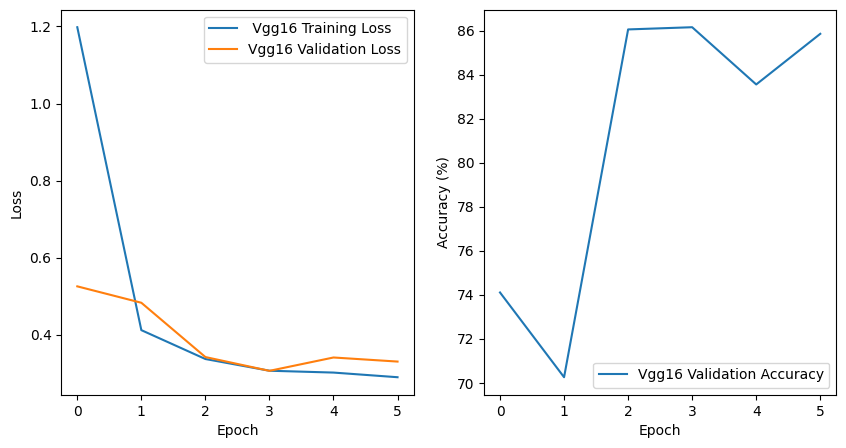

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses1, label = ' Vgg16 Training Loss')
plt.plot(valLosses1, label = 'Vgg16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs1, label = 'Vgg16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

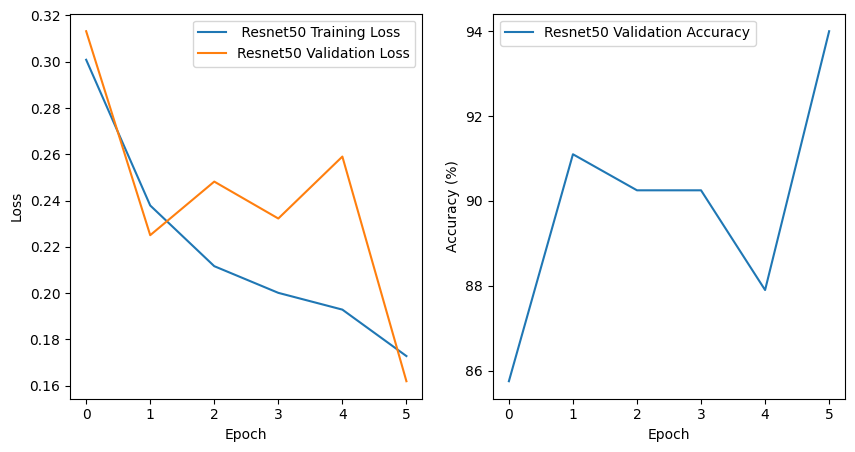

In [ ]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses2, label = ' Resnet50 Training Loss')
plt.plot(valLosses2, label = 'Resnet50 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs2, label = 'Resnet50 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

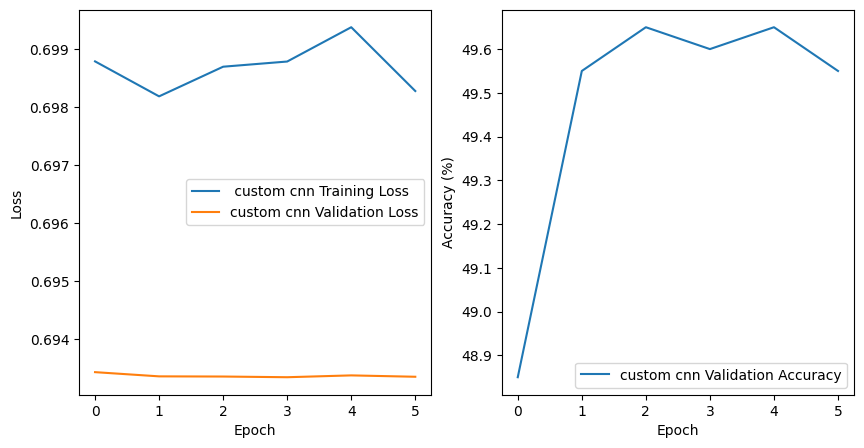

In [ ]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses3, label = ' custom cnn Training Loss')
plt.plot(valLosses3, label = 'custom cnn Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs3, label = 'custom cnn Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# confusion matrices

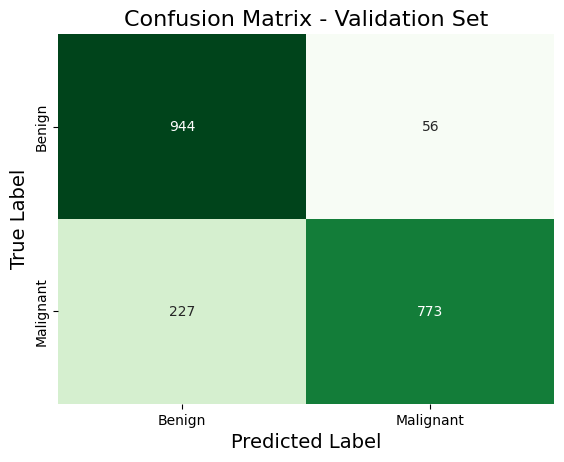

In [ ]:
# Plotting confusion matrix for validation data
model1.eval()
allLabels = []
allPreds1 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs1 = model1(inputs)
        predictions1 = (torch.sigmoid(outputs1) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds1.extend(predictions1.cpu().numpy())

allLabels = np.array(allLabels)
allPreds1 = np.array(allPreds1)

matrix1 = confusion_matrix(allLabels, allPreds1)

sns.heatmap(matrix1, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

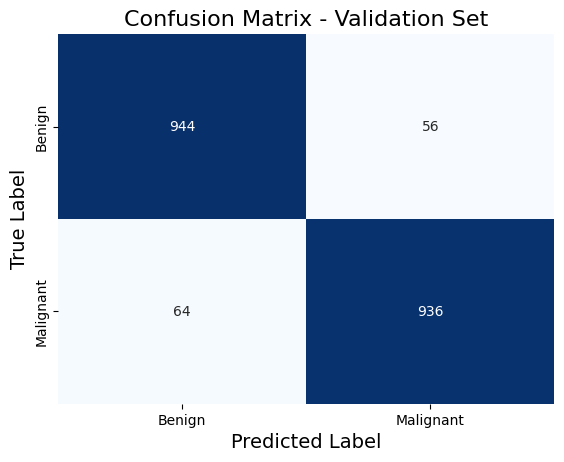

In [ ]:
model2.eval()
allLabels = []
allPreds2 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs2 = model2(inputs)
        predictions2 = (torch.sigmoid(outputs2) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds2.extend(predictions2.cpu().numpy())

allLabels = np.array(allLabels)
allPreds2 = np.array(allPreds2)

matrix2 = confusion_matrix(allLabels, allPreds2)

sns.heatmap(matrix2, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

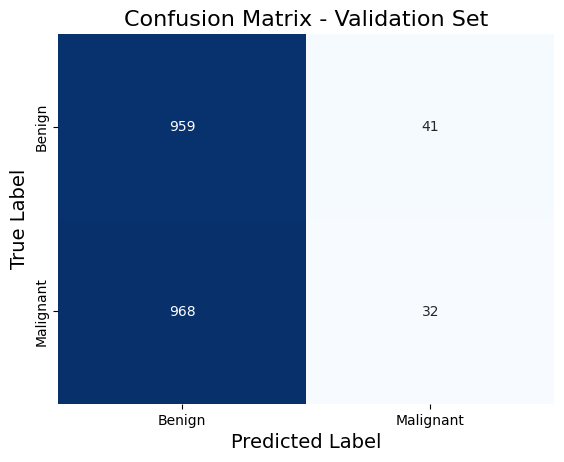

In [ ]:
model3.eval()
allLabels = []
allPreds3 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs3 = model3(inputs)
        predictions3 = (torch.sigmoid(outputs3) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds3.extend(predictions3.cpu().numpy())

allLabels = np.array(allLabels)
allPreds3 = np.array(allPreds3)

matrix3 = confusion_matrix(allLabels, allPreds3)

sns.heatmap(matrix3, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

# ensemble

In [ ]:
models = [model1, model2, model3]
#create_ensemble
allPreds = []

for model in models:
    model.eval()

with torch.no_grad():
    for inputs, _ in valLoader:
        inputs = inputs.to(device)
        batch_preds = []

        for model in models:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            batch_preds.append(probs)


        batch_preds = torch.stack(batch_preds, dim=0)
        batch_mean = batch_preds.mean(dim=0)


        preds = (batch_mean > 0.5).long()
        allPreds.append(preds.cpu())


final_preds = torch.cat(allPreds, dim=0)



In [ ]:
# evaluate_ensemble
y_true = []

for _, labels in valLoader:
    y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)

print(f"\n{'='*40}")
print(f"Evaluating Ensemble")
print(f"{'='*40}")

# Metrics
acc = accuracy_score(y_true, final_preds)
precision = precision_score(y_true, final_preds)
recall = recall_score(y_true, final_preds)
f1 = f1_score(y_true, final_preds)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Evaluating Ensemble
Accuracy: 92.90%
Precision: 0.9544
Recall: 0.9010
F1 Score: 0.9270



Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.96      0.93      1000
   Malignant       0.95      0.90      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



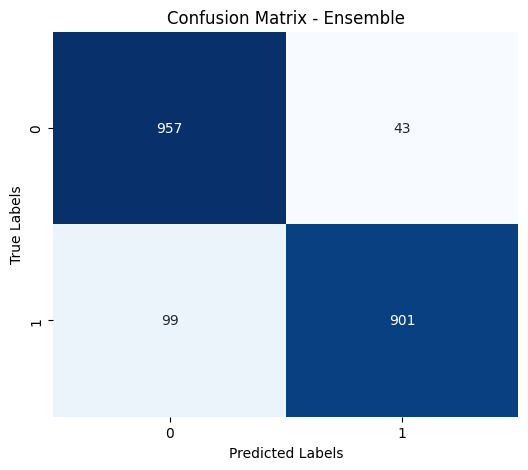

In [ ]:
from sklearn.metrics import classification_report
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, final_preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
cm = confusion_matrix(y_true, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Ensemble')
plt.show()